In [1]:
import sys
sys.path.append("../classes")
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from scipy.cluster import hierarchy
from sklearn.metrics import homogeneity_completeness_v_measure

from geno_classifier import *

from itertools import starmap, product
import re
import GEOparse
from random import randint
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

cmap = mcolors.LinearSegmentedColormap('my_colormap', cdict, 100)

In [3]:
diseases = ['leukemia',
            'glioma',
            'cervical_cancer',
            'pancreatic_cancer',
            'endometriosis',
            'breast_cancer_2',
            'colon_cancer',
            'prostate_cancer',
            'colorectal_cancer',
            'oral_carcinoma',
            'brain_cancer',
            'renal_carcinoma',
            'esophageal_carcinoma',
            'autism',
            'diabetes',
            'psoriasis',
            'lung_cancer_1',
            'H1N1',
            'HBV']

In [4]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)
def get_cancer_dataframe(results_path, labels_path, label, diff=True, pathways=True):
    c_results = pickle.load(open(results_path,'rb'))
    try:
        c_labels_ = pickle.load(open(labels_path,'rb'))["y"]
    except TypeError:
        c_labels_ = pickle.load(open(labels_path,'rb'))
    cancer, cancer_y = preprocess_results(c_results, c_labels_, 
                                                use_diff_score=diff, use_pathways=pathways, 
                                                scale=False, use_one_hot=False)

#     cancer.index = starmap(change_lable, product(c_labels_, [label]))
    return cancer, c_labels_

In [5]:
def get_Xys(diseases):
    nodiffs = {"X":dict(), "y":dict()}
    diffs = {"X":dict(), "y":dict()}
    for i, disease in enumerate(diseases):
        try:
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_Xy', disease,
                                                                diff=False, pathways=False)
            X, y = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_Xy', disease,
                                                                diff=True, pathways=True)
        except FileNotFoundError:
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_y', disease,
                                                                diff=False, pathways=False)
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_y', disease,
                                                                diff=True, pathways=True)

        nodiffs["X"][disease] = Xno
        nodiffs["y"][disease] = yno
        
        diffs["X"][disease] = X
        diffs["y"][disease] = y
    
    return diffs, nodiffs

In [6]:
# diffs, nodiffs = get_Xys(diseases)
# pickle.dump(diffs, open("../datasets/Xy_diffs", 'wb'))
# pickle.dump(nodiffs, open("../datasets/Xy_nodiffs", 'wb'))    

In [7]:
def load_Xs(Xy_diffs_path="../datasets/Xy_diffs", Xy_nodiffs_path="../datasets/Xy_nodiffs", include_healthy=False): 
    X_diffs = pickle.load(open(Xy_diffs_path, 'rb'))["X"]
    X_nodiffs = pickle.load(open(Xy_nodiffs_path, 'rb'))["X"]
    def chose_label(x, disease):
        disease = re.sub("_\d"," ",disease.strip())
        if include_healthy:
            return x
#             return x+"_"+disease
        else:
            return disease if "unhealthy" in x else np.NaN
    for X in [X_diffs, X_nodiffs]:
        for disease in diseases:
            X_diff = X[disease].reset_index()
            X_diff["index"] = X_diff["index"].apply(
                lambda x:chose_label(x, disease))
            X_diff.dropna(inplace=True)
            X[disease] = X_diff
    return X_diffs, X_nodiffs

In [8]:
X_diffs_h, X_nodiffs_h = load_Xs(include_healthy=True)

In [9]:
X_diffs, X_nodiffs = load_Xs()
Xs_ = pd.concat(X_diffs.values()).sample(frac=1).rename(columns={"index":"diseases"})

In [10]:
len(diseases), len(X_diffs), len(X_nodiffs)

(19, 19, 19)

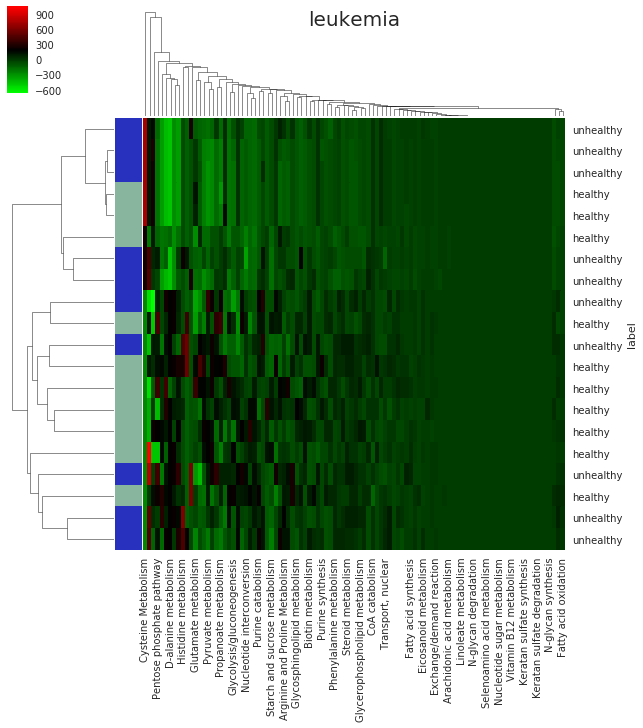

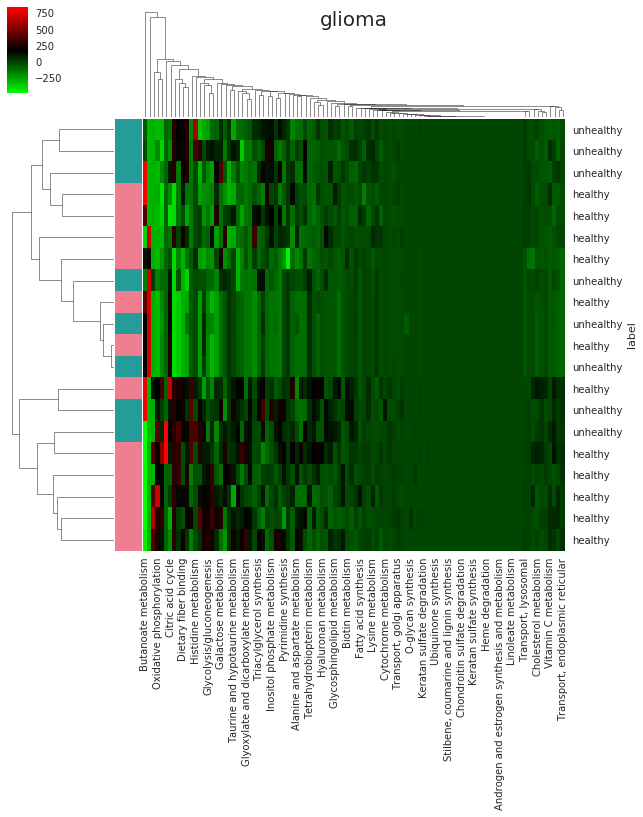

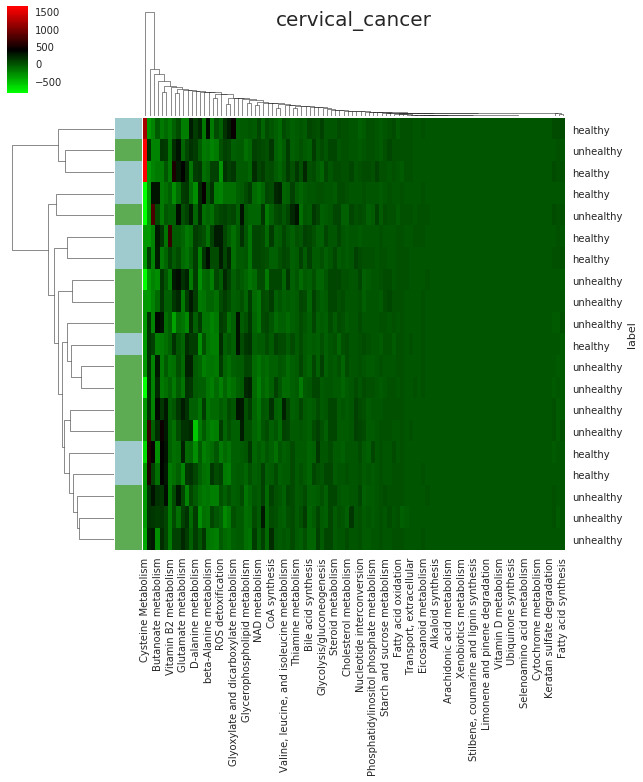

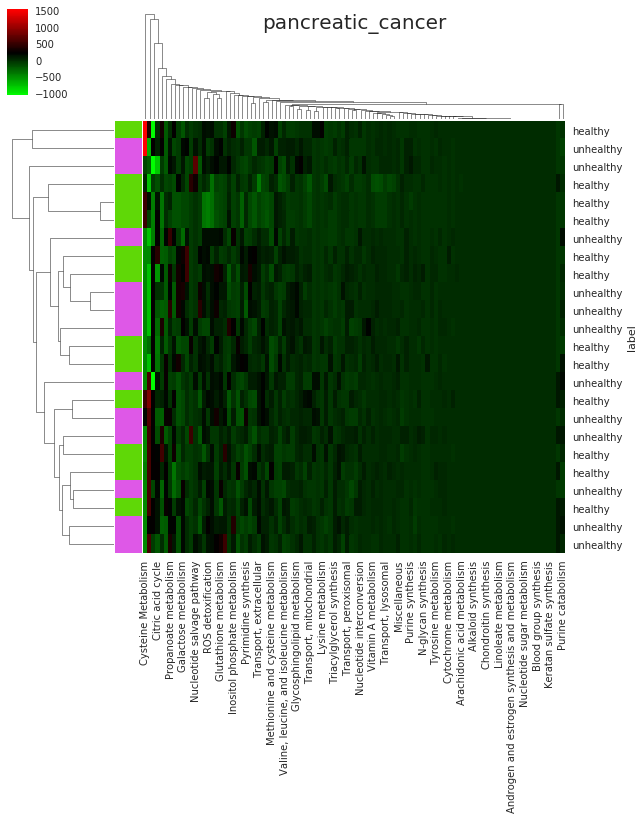

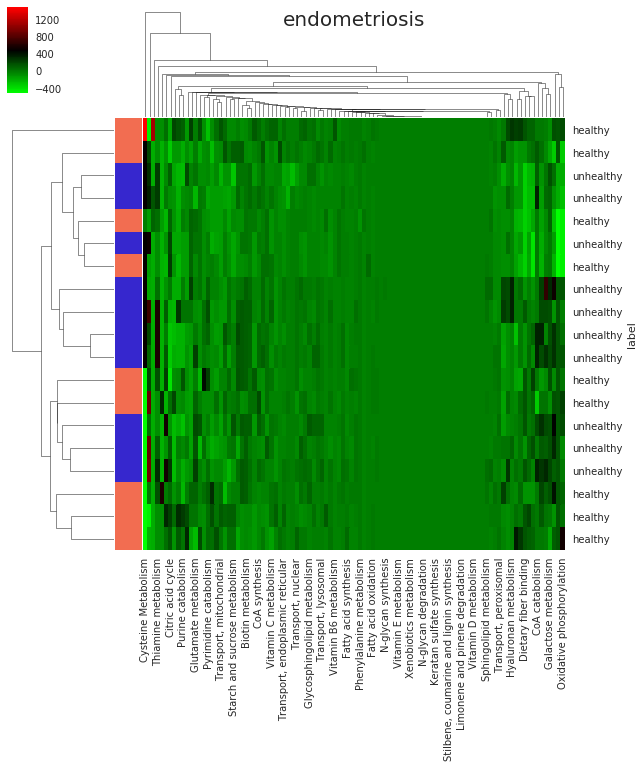

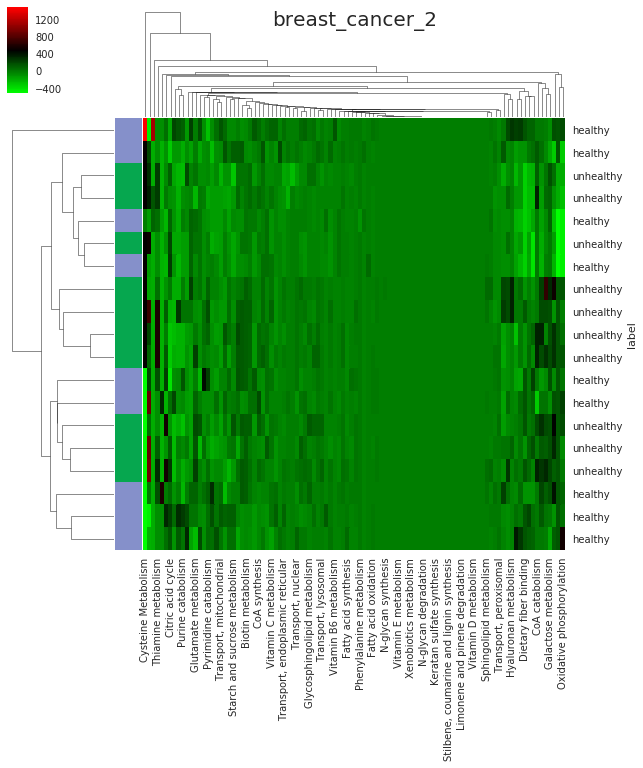

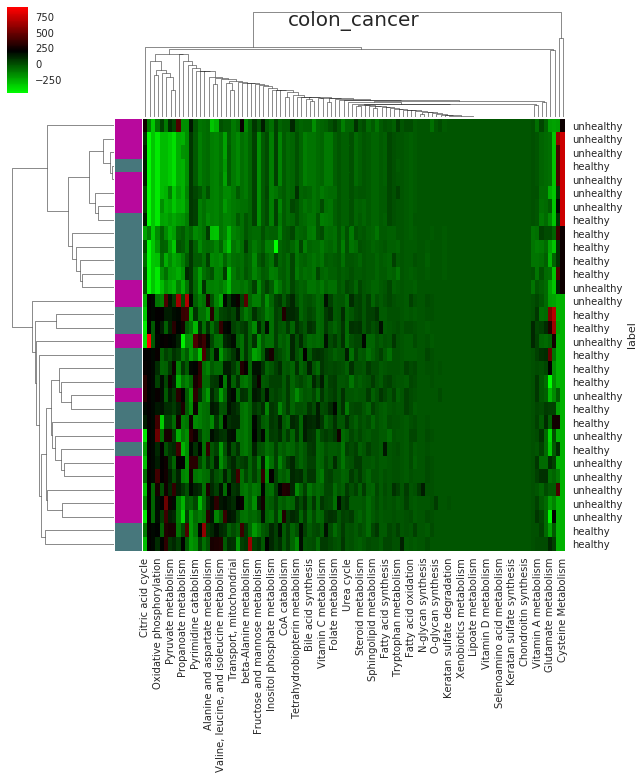

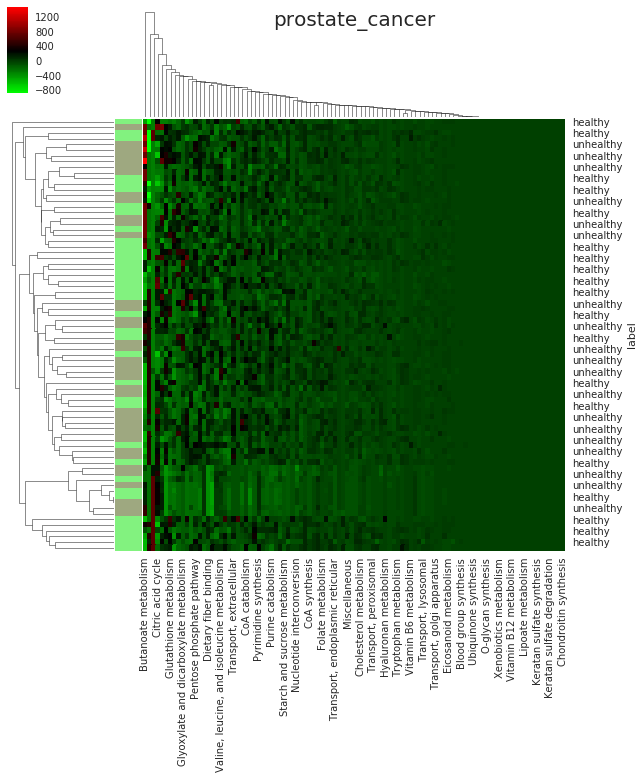

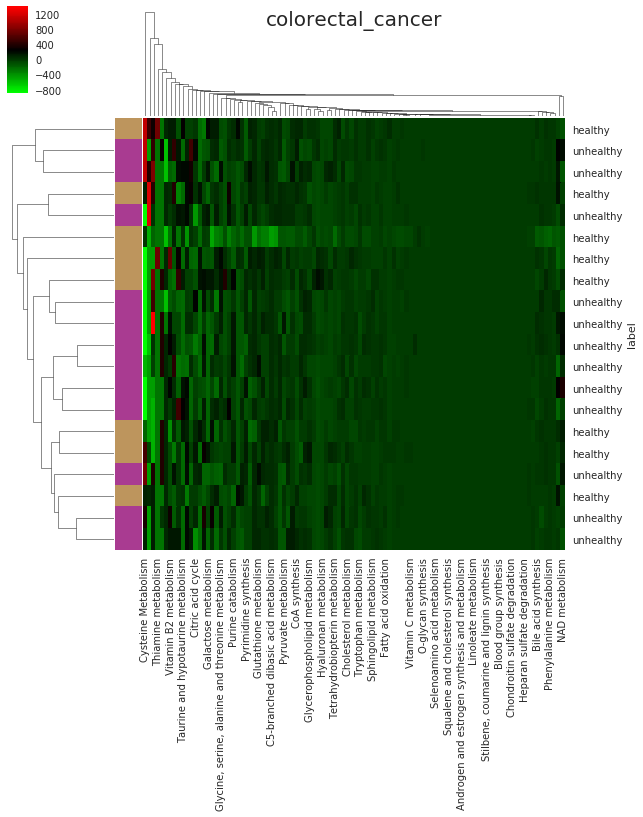

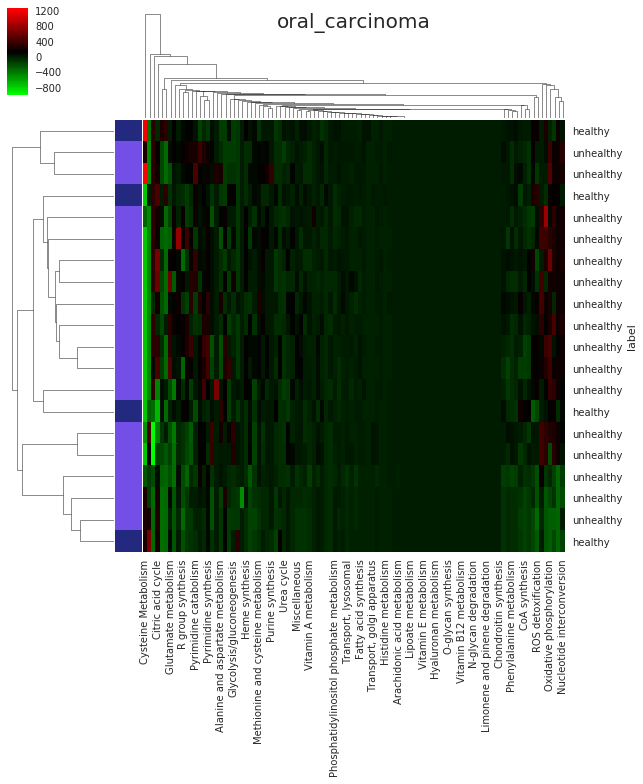

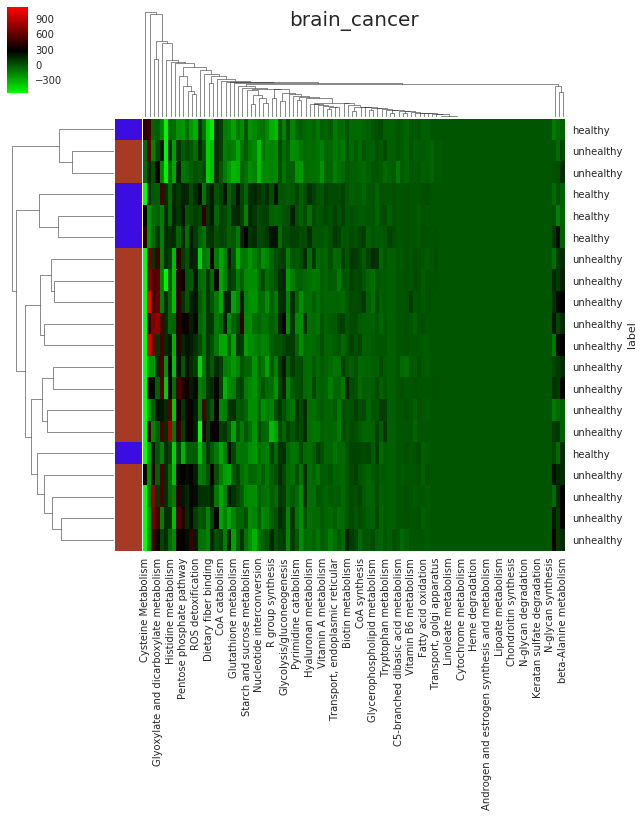

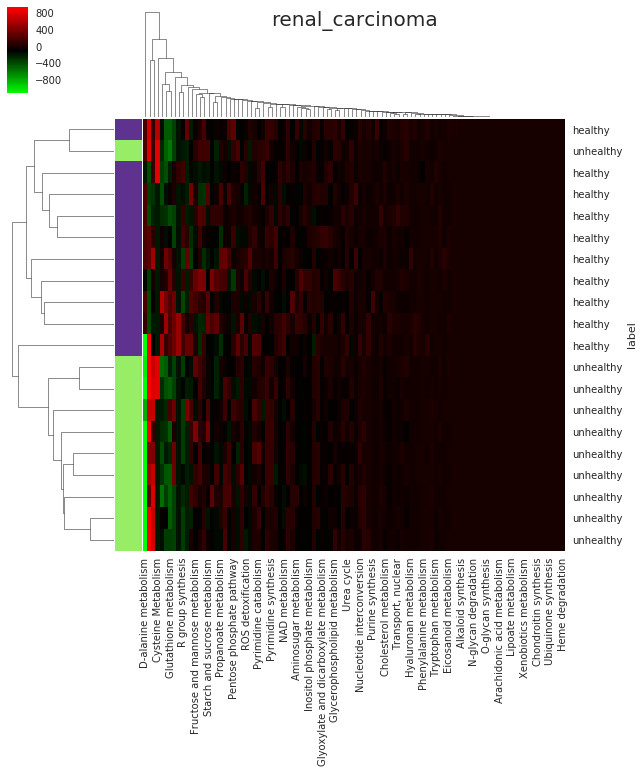

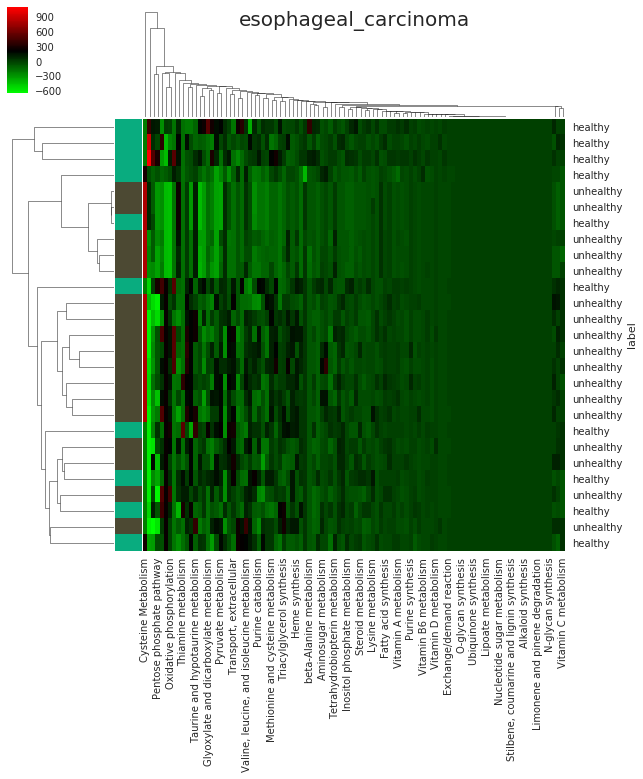

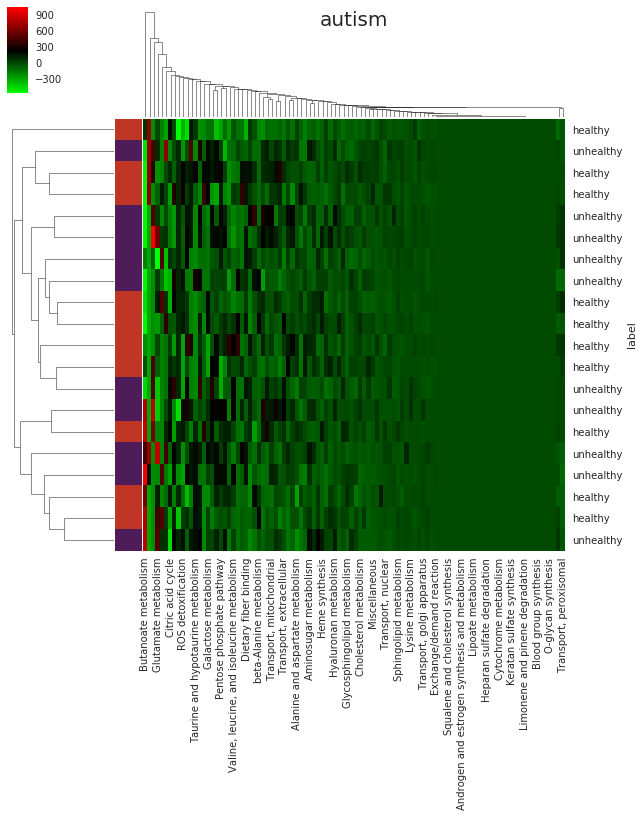

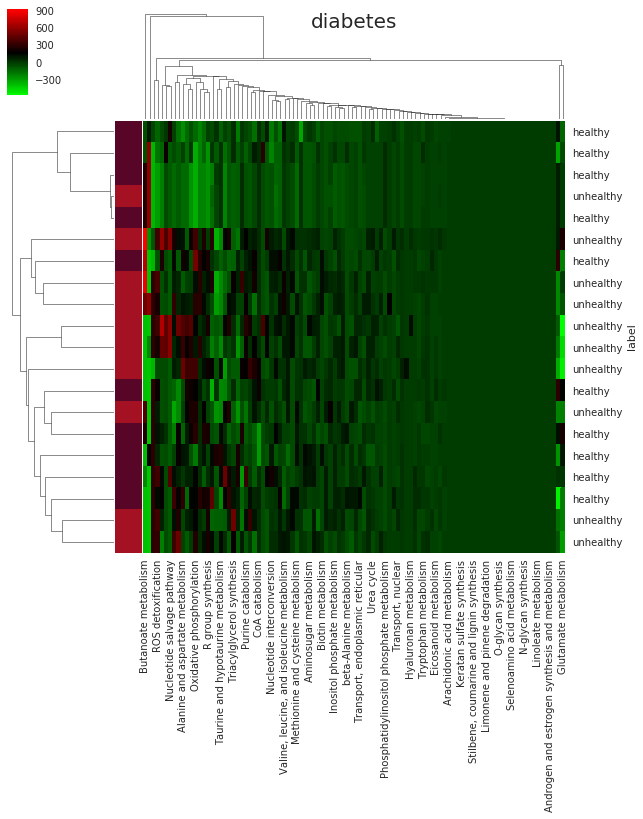

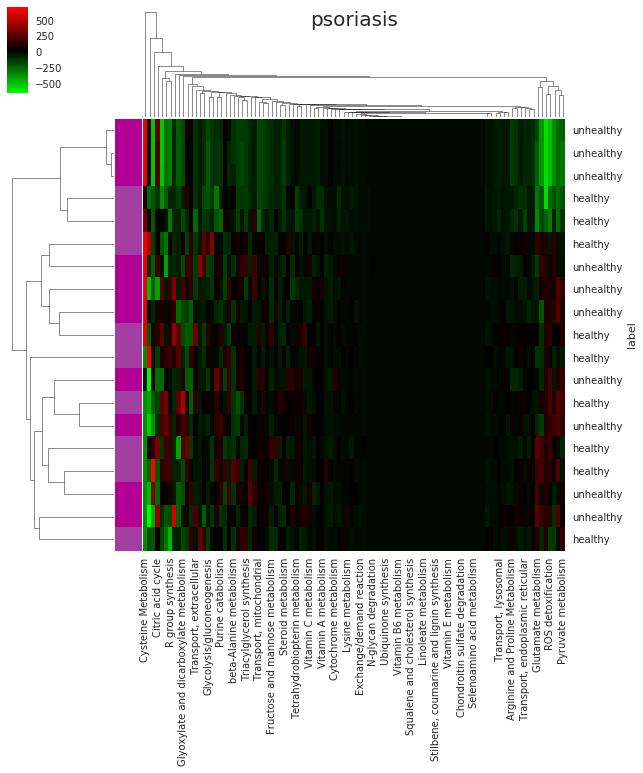

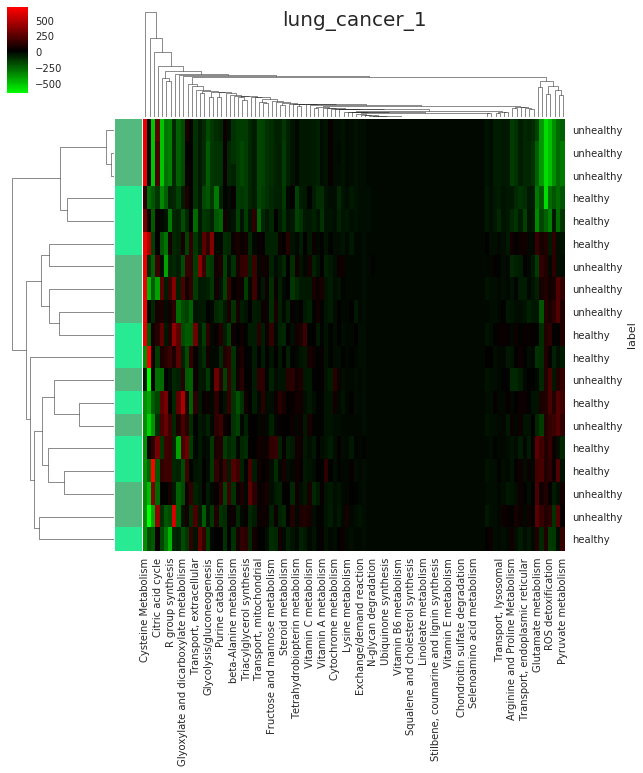

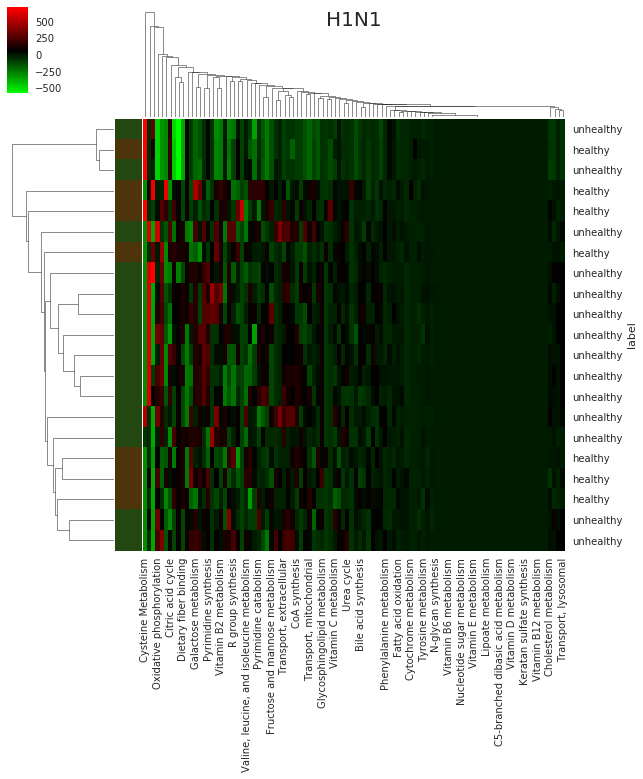

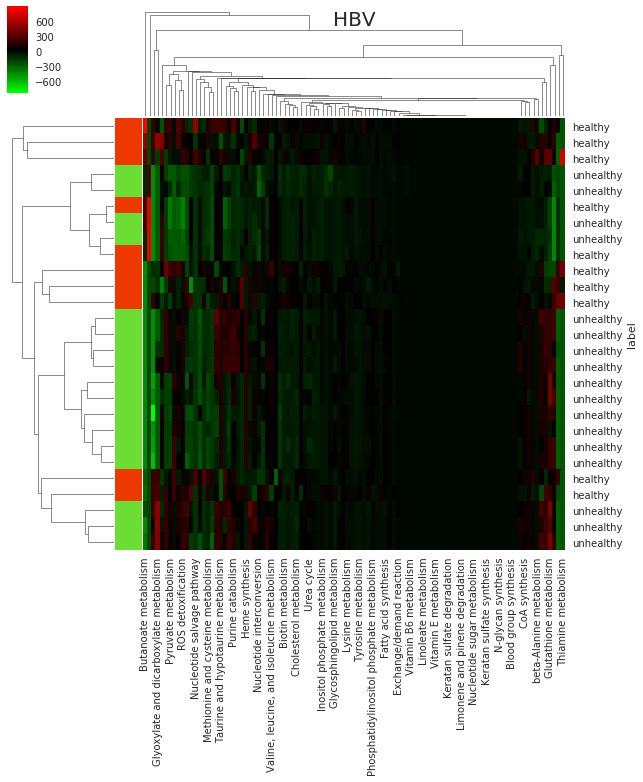

In [11]:
for disease in diseases:
    Xs = X_diffs_h[disease].rename(columns={"index":"label"})
    disease_labels = Xs["label"]
    Xs.set_index("label", inplace=True)
    unique = disease_labels.unique()
    colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(unique))]
    lut = dict(zip(unique, colors))
    row_colors = disease_labels.map(lut)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title(disease, y=1.2, fontsize=20)

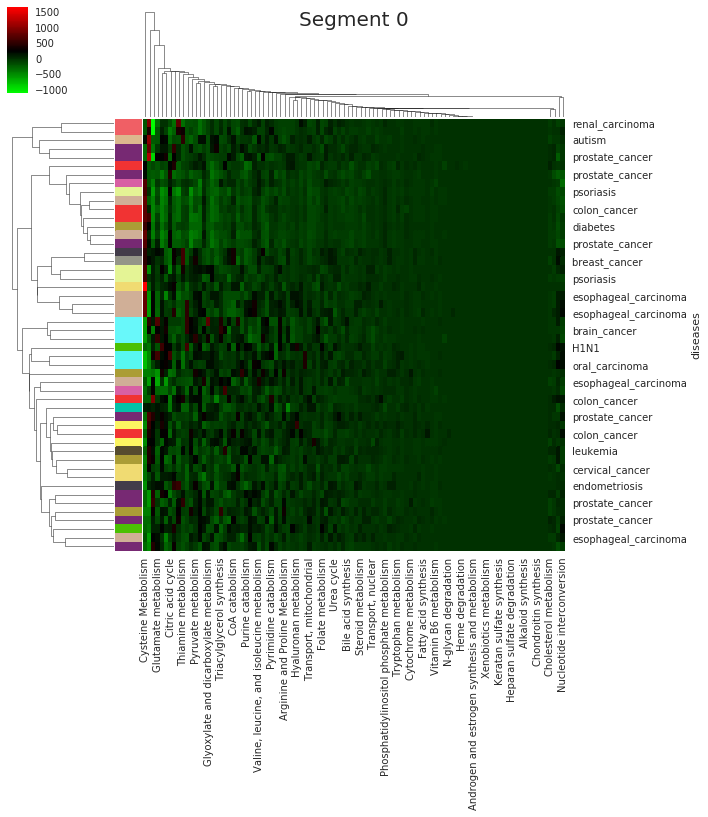

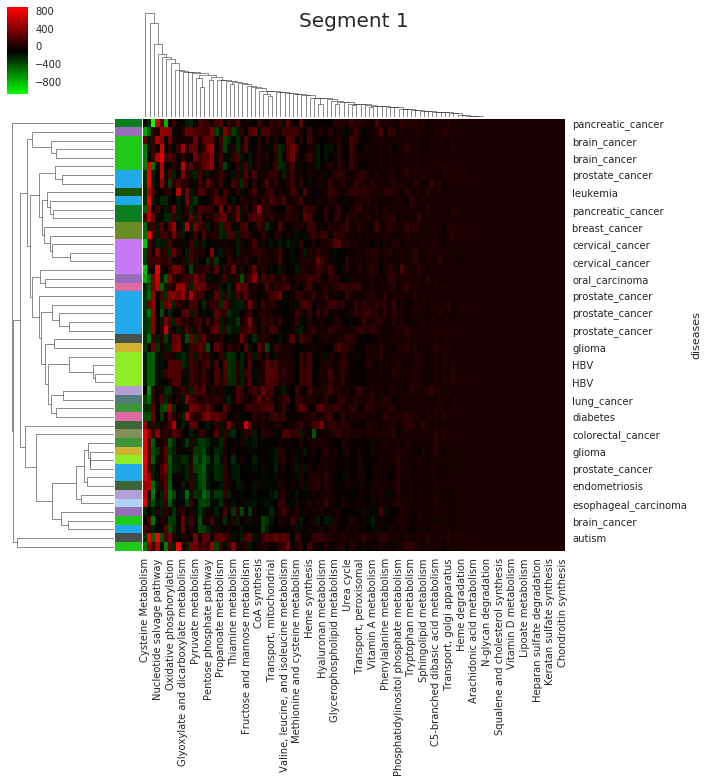

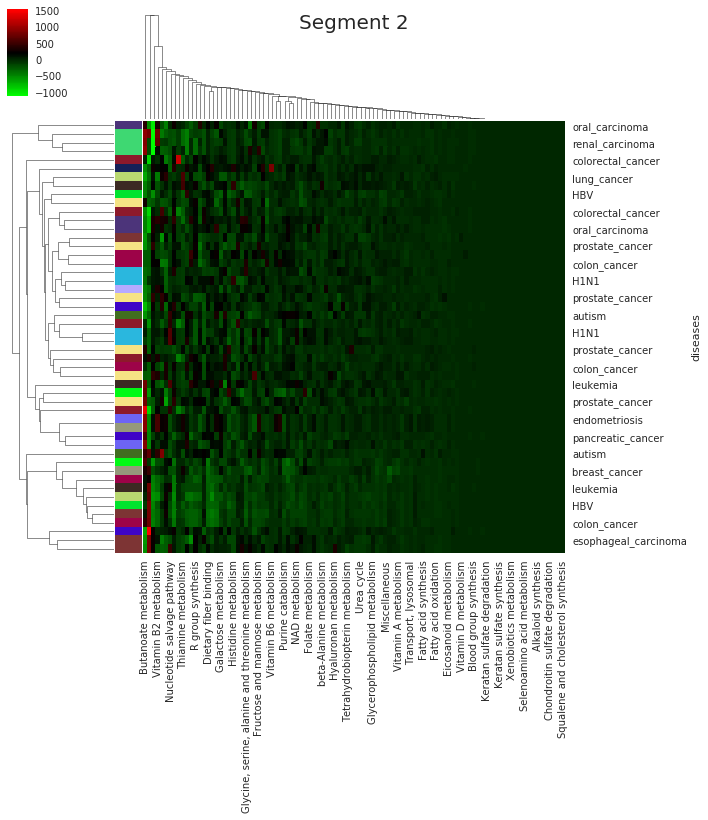

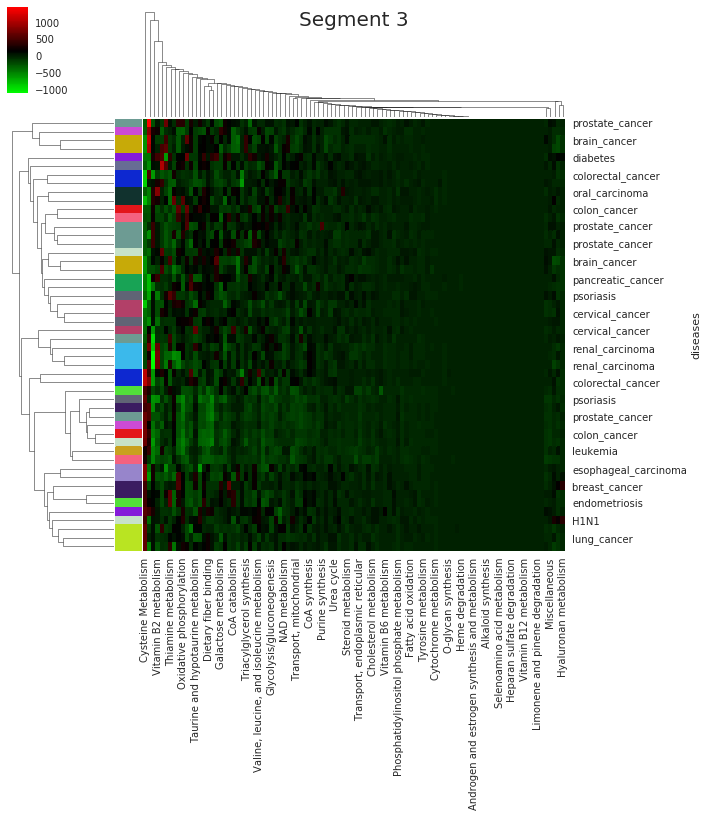

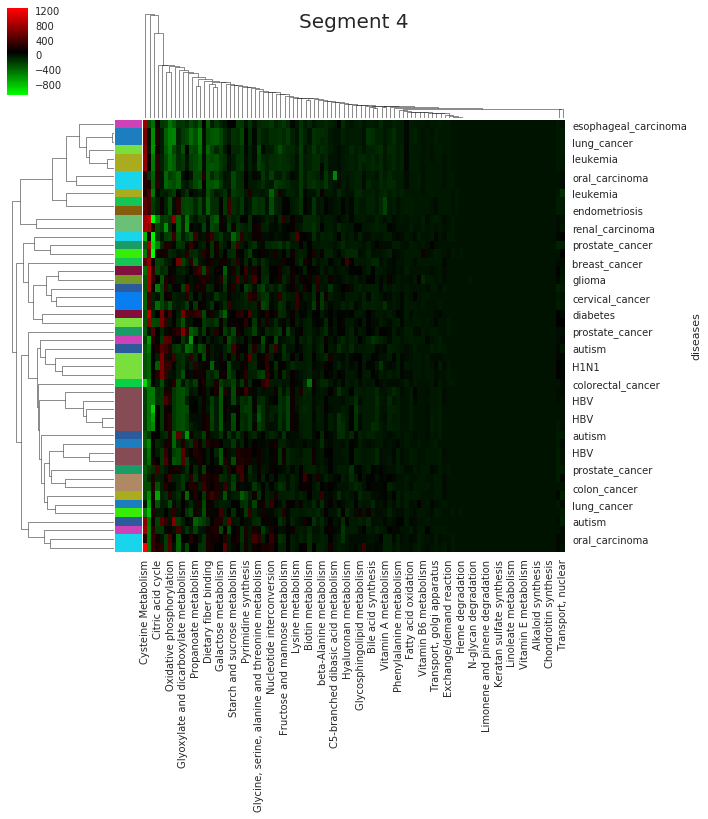

In [12]:
segments = 50
for i in range(int(len(Xs_)/segments)):
    Xs = Xs_[i*segments:(i+1)*segments]
    disease_labels = Xs["diseases"]
    Xs.set_index("diseases", inplace=True)
    unique = disease_labels.unique()
    colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(unique))]
    lut = dict(zip(unique, colors))
    row_colors = disease_labels.map(lut)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title("Segment {}".format(i), y=1.2, fontsize=20)

In [13]:
disease_labels = Xs_["diseases"]
Xs_.set_index("diseases", inplace=True)

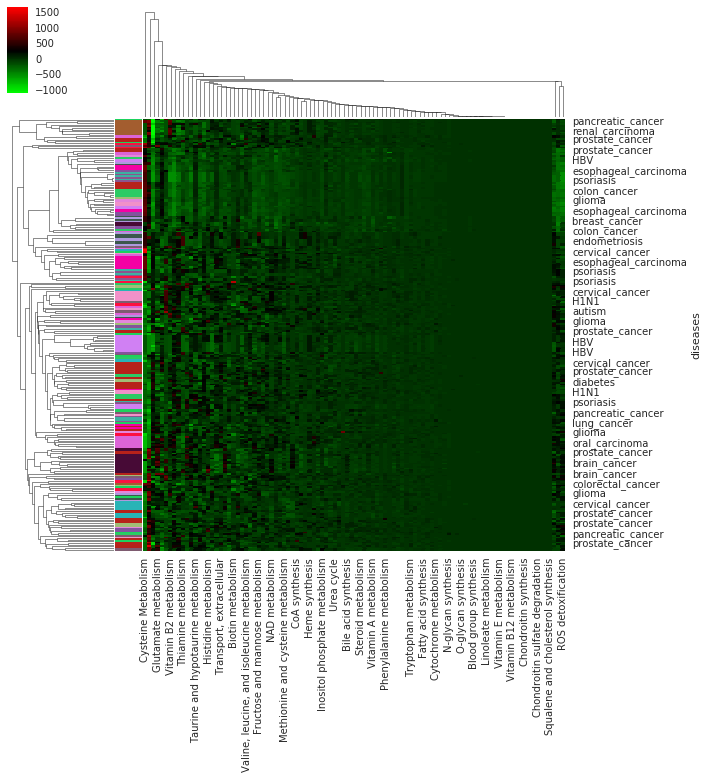

In [14]:
unique = disease_labels.unique()
colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(unique))]
lut = dict(zip(unique, colors))
row_colors = disease_labels.map(lut)
g = sns.clustermap(Xs_, row_colors=list(row_colors), cmap=cmap)

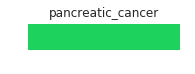

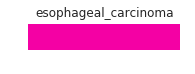

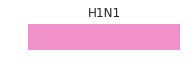

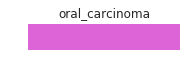

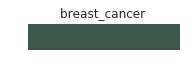

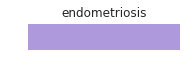

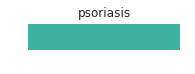

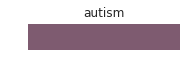

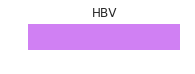

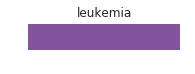

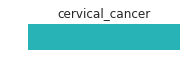

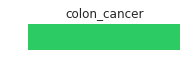

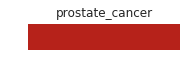

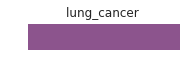

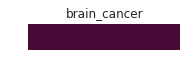

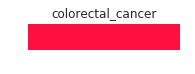

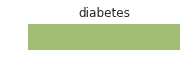

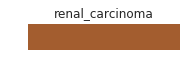

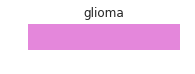

In [15]:
for disease, color in lut.items():
    plt.figure(figsize=(3,0.5))
    plt.bar([1],[1], color=color)
    plt.axis('off')
    plt.title(disease)

# Using no diff values

In [16]:
Xs_nodiff = pd.concat(X_nodiffs.values()).sample(frac=1).rename(columns={"index":"diseases"})

RecursionError in glioma
RecursionError in cervical_cancer
RecursionError in pancreatic_cancer
RecursionError in prostate_cancer
RecursionError in colorectal_cancer
RecursionError in renal_carcinoma
RecursionError in autism
RecursionError in H1N1


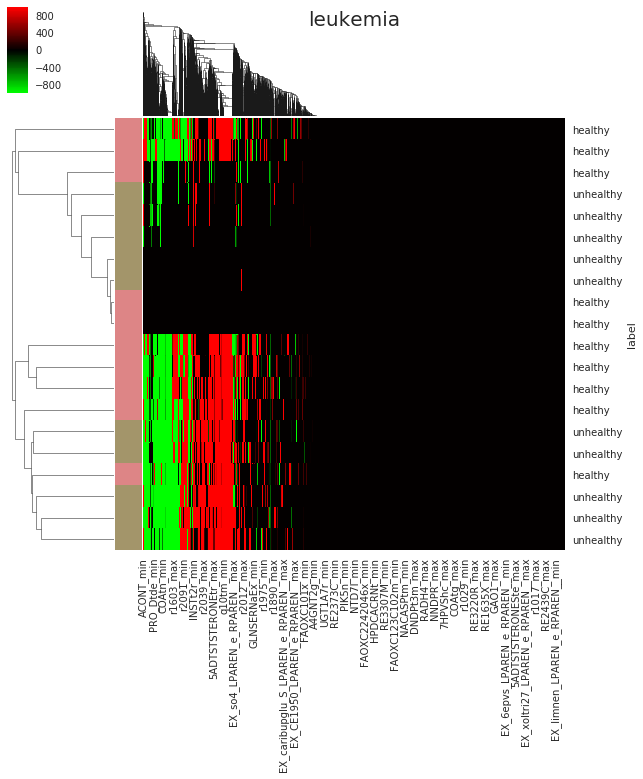

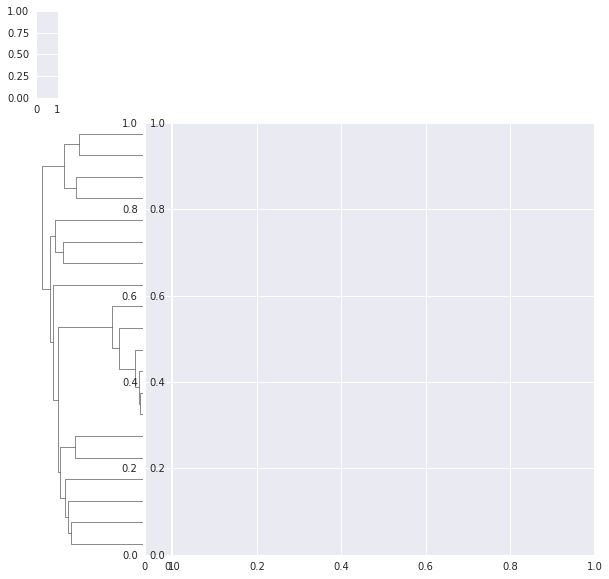

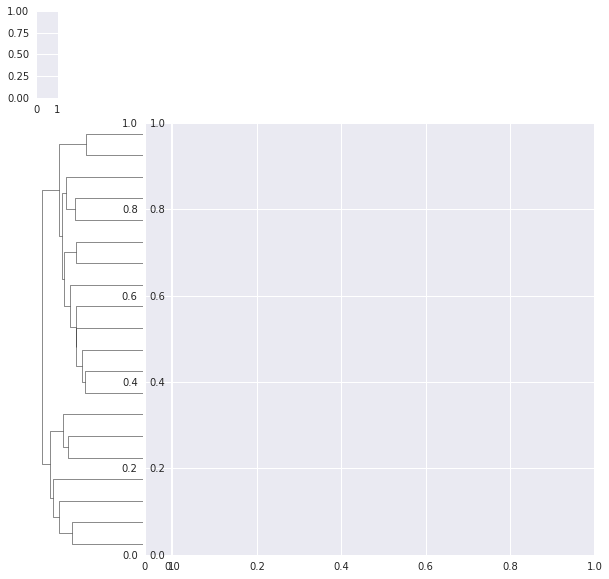

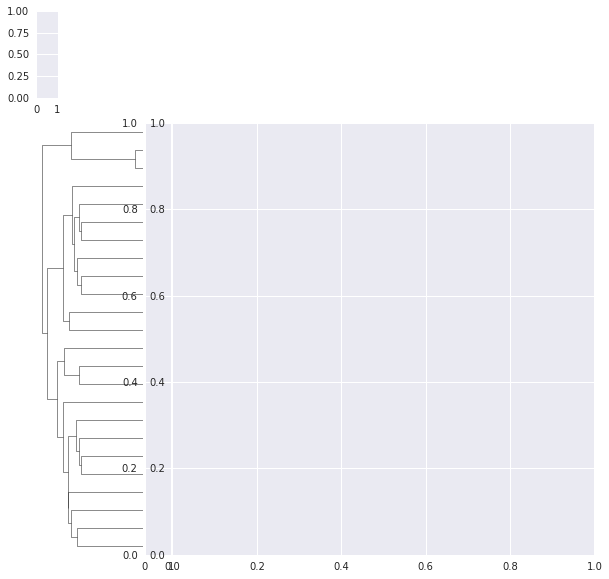

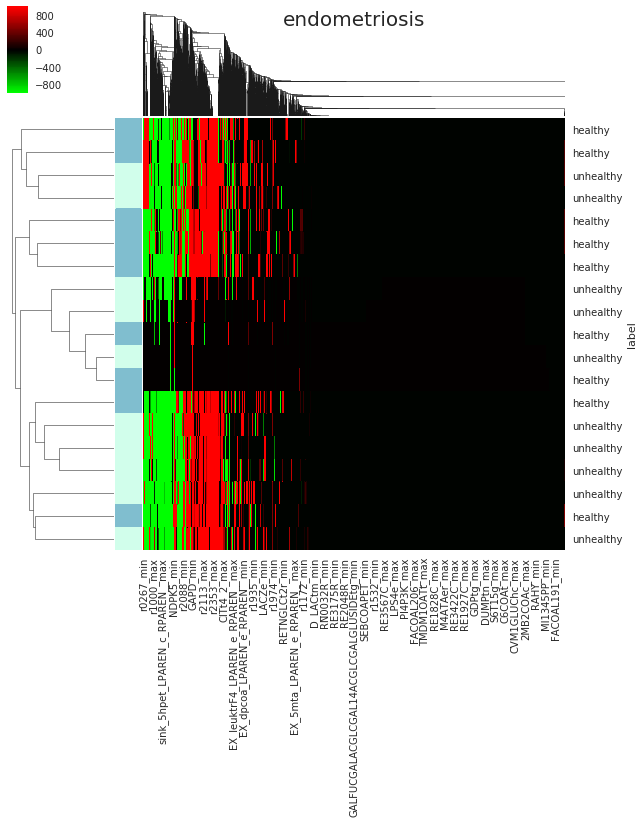

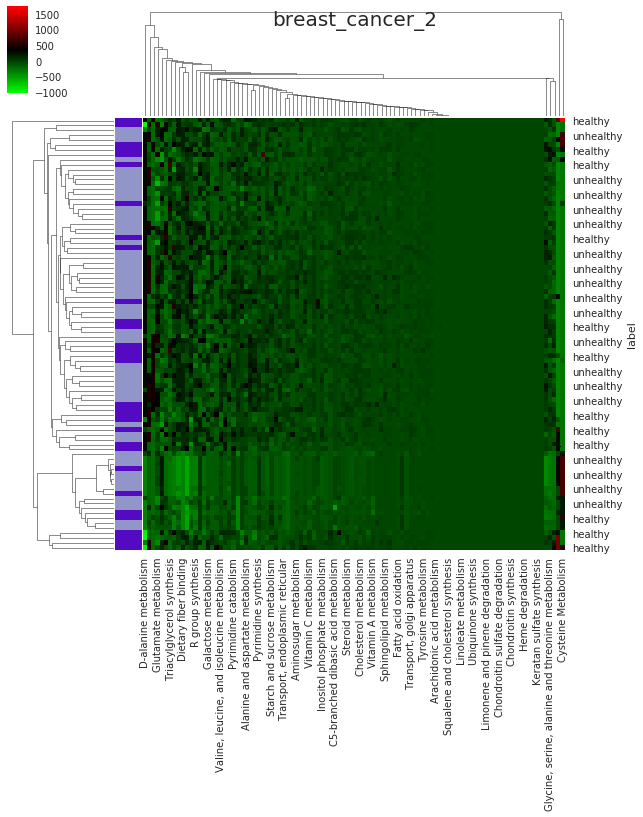

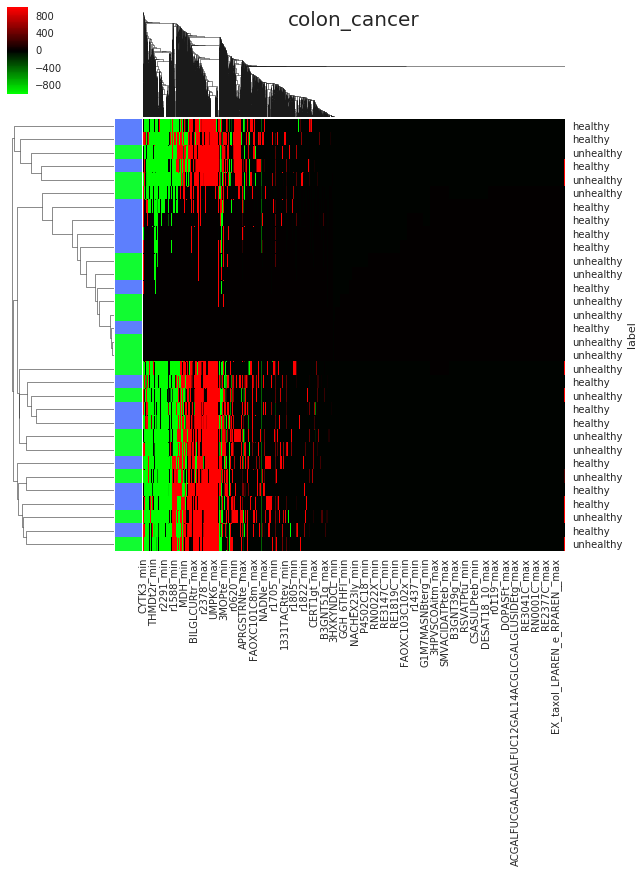

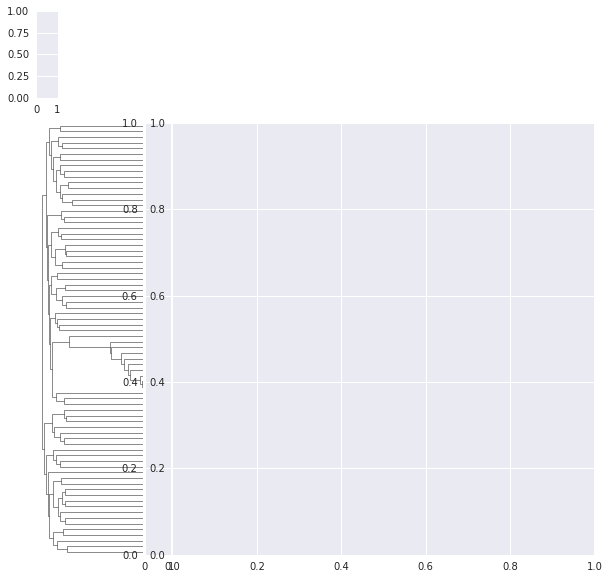

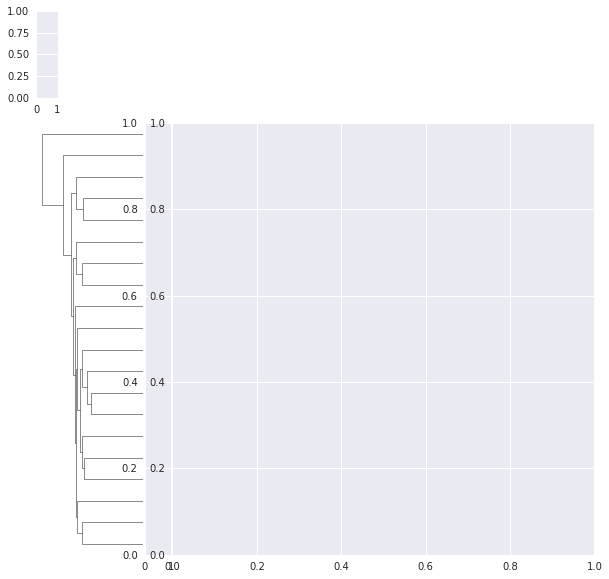

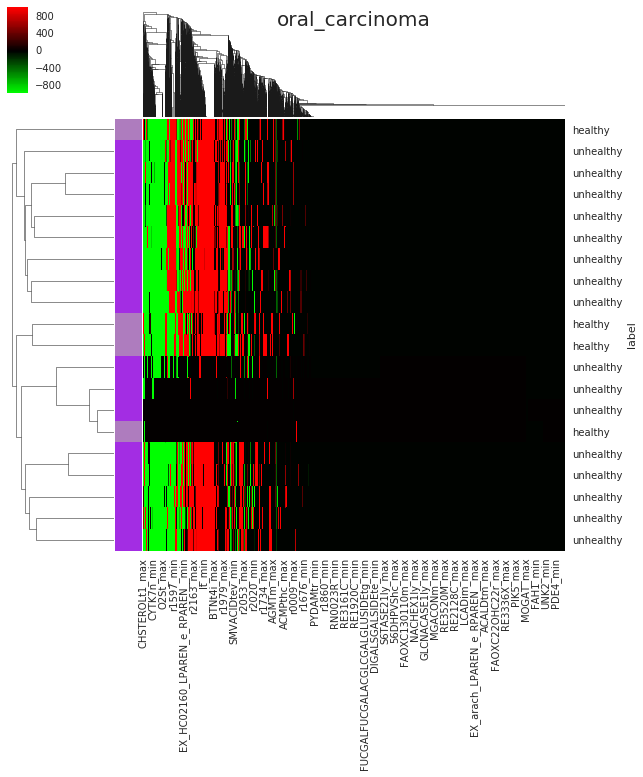

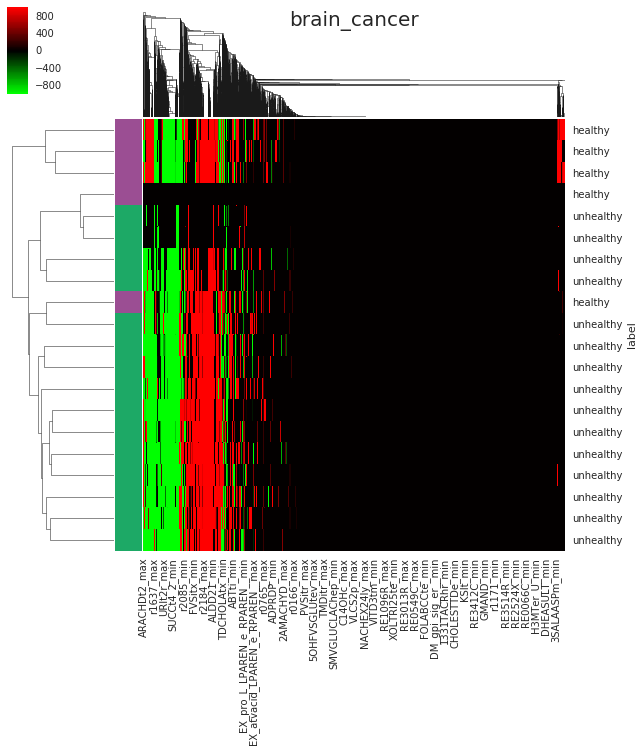

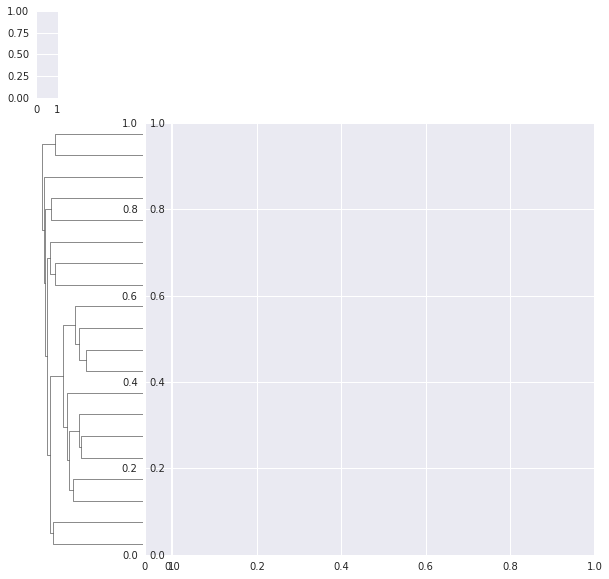

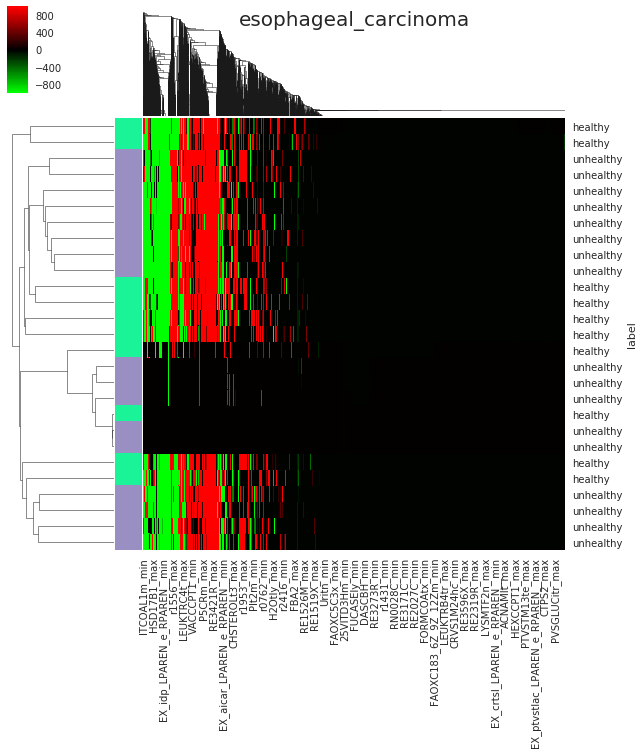

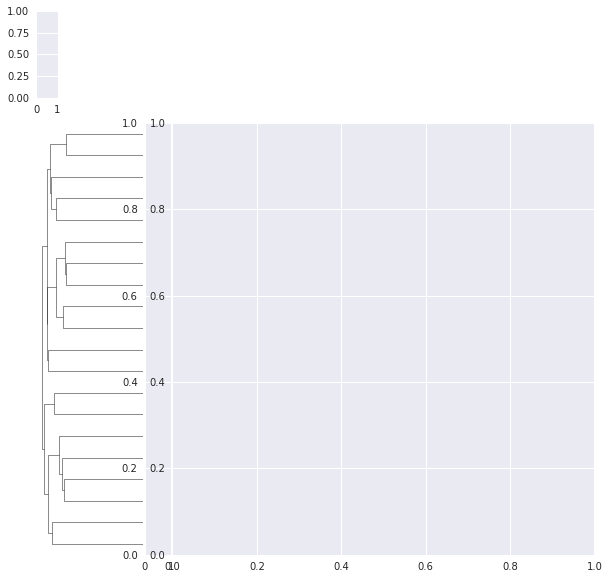

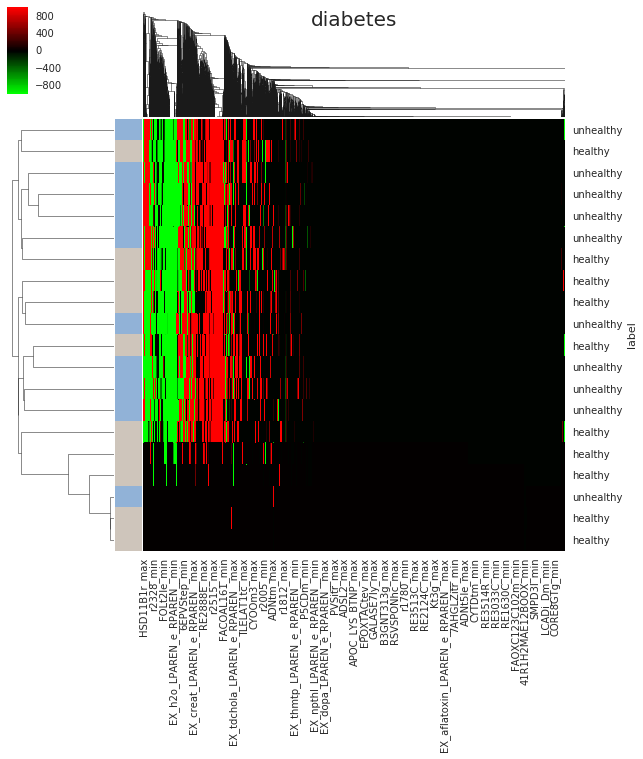

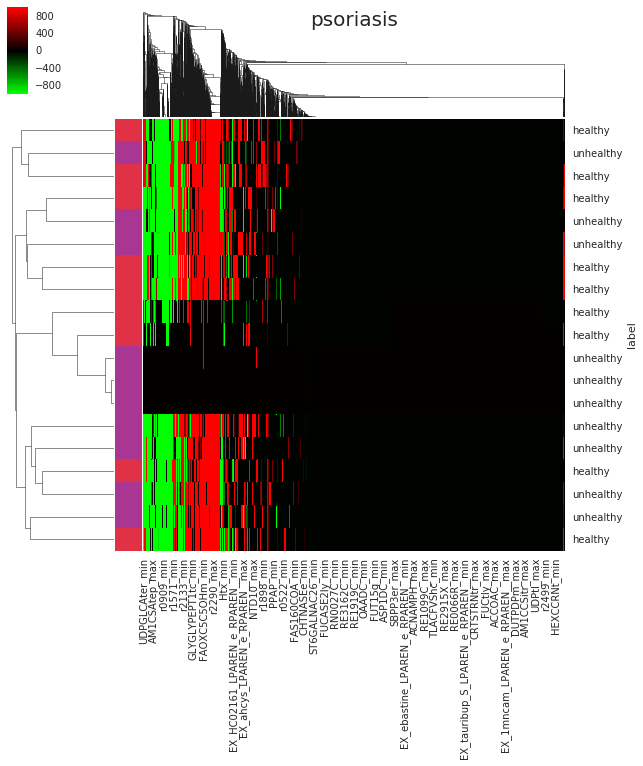

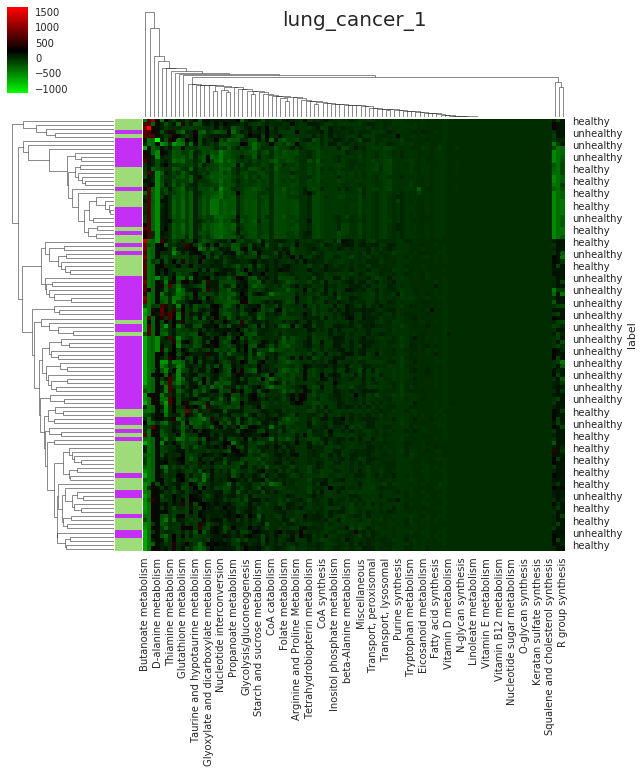

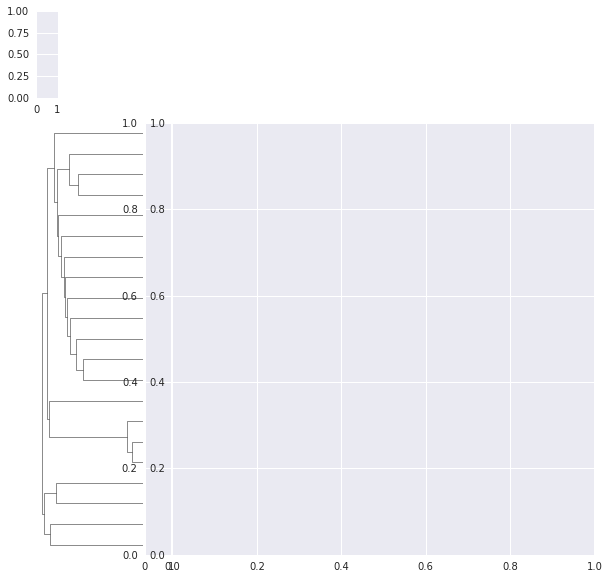

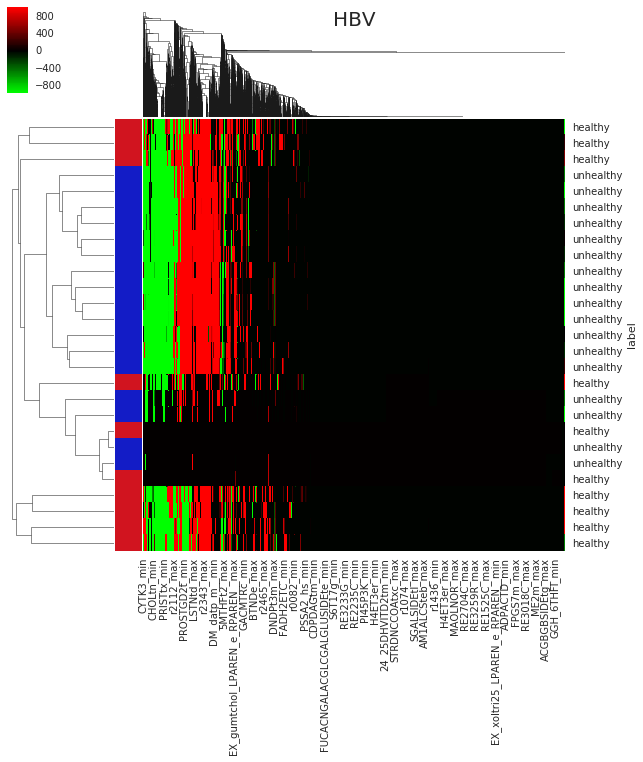

In [17]:
for disease in diseases:
    try:
        Xs = X_nodiffs_h[disease].rename(columns={"index":"label"})
        disease_labels = Xs["label"]
        Xs.set_index("label", inplace=True)
        unique = disease_labels.unique()
        colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(unique))]
        lut = dict(zip(unique, colors))
        row_colors = disease_labels.map(lut)
        g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
        ax = g.ax_heatmap
        ax.set_title(disease, y=1.2, fontsize=20)
    except RecursionError:
        print("RecursionError in {}".format(disease))
        continue